# Building out the merger

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import arabicABC as abc
from fuzzywuzzy import fuzz

Reading texts

In [2]:
afifi = pd.read_csv('AfifiCleaned.csv')

In [3]:
textAfifi = afifi['letters'][2:].tolist()

In [4]:
lakhnawi = pd.read_csv('fusus.csv', dtype={"page":int, "line":int, "column":int, "span":int, "direction": str, 
                                        "left":"Int64", "top":"Int64", "right":"Int64", "bottom":"Int64", 
                                        "word":str, "short":str, "haspunct":str, "punctAfter":str, "punctBefore":str, 
                                        "QunawiMS":str, "poetryMeter":str, "poetryVerse":"Int64", "fass":"Int64", "lwcvl":str, 
                                        "quran":str})
lakhnawi.word = lakhnawi.word.fillna('')
lakhnawi.short = lakhnawi.short.fillna('')
lakhnawi.haspunct = lakhnawi.haspunct.fillna('')
lakhnawi.punctAfter = lakhnawi.punctAfter.fillna('')
lakhnawi.punctBefore = lakhnawi.punctBefore.fillna('')
lakhnawi.poetryMeter = lakhnawi.poetryMeter.fillna('')
lakhnawi.lwcvl = lakhnawi.lwcvl.fillna('')
lakhnawi.quran = lakhnawi.quran.fillna('')

In [5]:
textLakhnawi = lakhnawi['short']

Algorithme

In [6]:
nameA = "Afifi"
nameB = "Lakhnawi"
textA = textAfifi
textB = textLakhnawi
x0 = 0
x1 = 0
i = 0
comparativeIndex = {}
fuzzResults = {}

# while x0 < len(textA) and x1 < len(textB):
while x0 < 100:
    if textA[x0] == textB[x1]:
        comparativeIndex[i] = [x0, x1]
        x0 += 1
        x1 += 1
        fuzzResults[i] = ['same','']
    else:
        anteLocus = (abc.rasm(textA[x0-1]), abc.rasm(textB[x1-1]))
        postLocus = (abc.rasm(textA[x0+1]), abc.rasm(textB[x1+1]))
        sicLocus = (abc.rasm(textA[x0]), abc.rasm(textB[x1]))
        sicfuzz = fuzz.ratio(sicLocus[0],sicLocus[1])
        if sicfuzz >= 80:
            comparativeIndex[i] = [x0, x1]
            fuzzResults[i] = ['sameish','SICFUZZ '+str(sicfuzz)]
            x0 += 1
            x1 += 1
        elif fuzz.ratio(anteLocus[0],anteLocus[1]) > 80 and fuzz.ratio(postLocus[0],postLocus[1]) > 80:
            comparativeIndex[i] = [x0, x1]
            fuzzResults[i] = ['different word','Sicfuzz '+str(sicfuzz)]
            x0 += 1
            x1 += 1
        else:
            postpostLocus = (abc.rasm(textA[x0+2]), abc.rasm(textB[x1+2]))
            
            sicApostBfuzz = fuzz.ratio(sicLocus[0],postLocus[1])
            postApostpostBfuzz = fuzz.ratio(postLocus[0],postpostLocus[1])
            
            postAsicBfuzz = fuzz.ratio(postLocus[0],sicLocus[1])
            postpostApostBfuzz = fuzz.ratio(postpostLocus[0],postLocus[1])
            
            if sicApostBfuzz > 80 and postApostpostBfuzz > 80:
                comparativeIndex[i] = [x0, None]
                fuzzResults[i] = ['A unique','Sicfuzz '+str(sicfuzz)]
                x0+=1
            elif postAsicBfuzz > 80 and postpostApostBfuzz > 80:
                comparativeIndex[i] = [None, x1]
                fuzzResults[i] = ['B unique','Sicfuzz '+str(sicfuzz)]
                x1+=1
            
#             elif postAsicBfuzz == sicApostBfuzz:
#                 fuzzswap = fuzz.ratio(abc.rasm(textA[x0+2]),abc.rasm(textB[x1+2]))
#                 if antefuzz > 80 and fuzzswap > 80:
#                     comparativeIndex[i] = [x0, x1]
#                     fuzzResults[i] = ['wordswap','sicfuzz '+str(sicfuzz)]
#                     x0 += 1
#                     x1 += 1
            else:
                comparativeIndex[i] = [None, None]
                fuzzResults[i] = ['unsure','Sicfuzz '+str(sicfuzz)]
    i+=1

y=0
for i in range(len(comparativeIndex)):
    if comparativeIndex[i][0] == None:
        A = "***"
    else:
        A = textA[comparativeIndex[i][0]]
    if comparativeIndex[i][1] == None:
        B = "***"
    else:
        B = textB[comparativeIndex[i][1]]
#     print('INDEX',comparativeIndex[i])
#     print(nameA,A)
#     print(nameB,B)
#     if y in fuzzResults:
#         print(fuzzResults[y])
    y+=1
#     print(" ")

KeyboardInterrupt: 

Visualizering

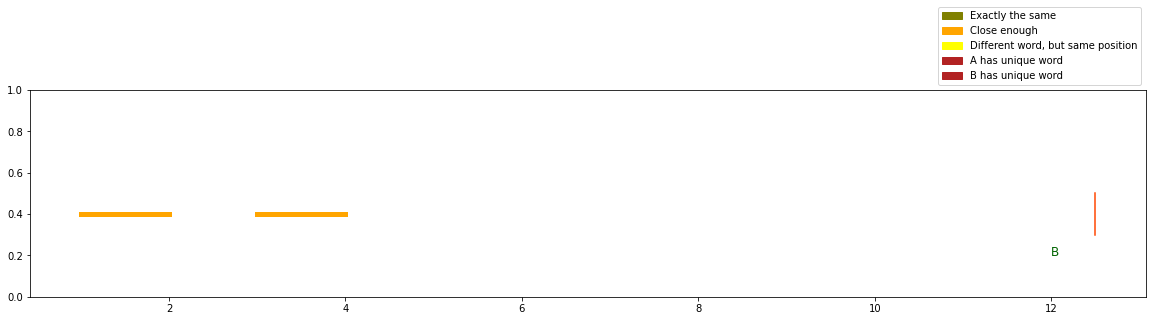

In [29]:
plt.figure(figsize=(20,5))
plt.autoscale(enable=False, axis='y')
xValues = []
yValues = []

olive_patch = mpatches.Patch(color='olive', label='Exactly the same')
orange_patch = mpatches.Patch(color='orange', label='Close enough')
yellow_patch = mpatches.Patch(color='yellow', label='Different word, but same position')
firebrick_patch = mpatches.Patch(color='firebrick', label='A has unique word')
orangered_patch = mpatches.Patch(color='firebrick', label='B has unique word')

plt.legend(handles=[olive_patch, orange_patch, yellow_patch, firebrick_patch,orangered_patch],bbox_to_anchor=(1, 1),loc='lower right')

# for i in range(len(comparativeIndex)):
for i in range(0,300):
    if i in fuzzResults:
        if fuzzResults[i][0] == 'sameish':
            plt.plot([i,i+1],[0.4,0.4], color='Orange',linewidth=5)
        elif fuzzResults[i][0] == 'A unique' or fuzzResults[i][0] == 'unsure of wordswap, making A unique':
            plt.plot([(i+i+1)/2,(i+i+1)/2],[0.3,0.5], color='firebrick')
            plt.text(i, 0.6, "A", fontsize=12, color='Darkgreen')
        elif fuzzResults[i][0] == 'B unique':
            plt.plot([(i+i+1)/2,(i+i+1)/2],[0.3,0.5], color='orangered')
            plt.text(i, 0.2, "B", fontsize=12, color='Darkgreen')
        elif fuzzResults[i][0] == 'different word':
            plt.plot([i,i+1],[0.4,0.4], color='Yellow', linewidth=5)
    else:
        plt.plot([i,i+1],[0.4,0.4], color='olive')
plt.subplots_adjust(top=0.7)
plt.savefig('MerginTwoEditions.jpg')

In [23]:
textAfifi[364:371]

['ما', 'سؤى', 'محل', 'إلا', 'ويقبل', 'روحا', 'إلهيا']

In [13]:
textLakhnawi[368:378]

368       ما
369      سوى
370     محلا
371      إلا
372      ولا
373       بد
374       أن
375     يقبل
376     روحا
377    إلهيا
Name: short, dtype: object

In [22]:
abc.rasm(textAfifi[368])

'يفبل'

In [21]:
abc.rasm(textLakhnawi[375])

'يفبل'

In [20]:
fuzz.ratio(abc.rasm(textAfifi[366]),abc.rasm(textLakhnawi[370]))

86